In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

In [2]:
PATH = 'Data/'

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [3]:
batch_size = 128
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 599 files belonging to 8 classes.
Using 480 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 599 files belonging to 8 classes.
Using 119 files for validation.


In [6]:
CLASS_NAMES = train_ds.class_names
print(CLASS_NAMES)

['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri', 'mohiniyattam', 'odissi', 'sattriya']


In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 180, 180, 3)
(128,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [12]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,(3,3), padding='same', activation='relu',input_shape=(180, 180, 3)),
    layers.Conv2D(32,(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), padding='same', activation='relu'),
    layers.Conv2D(64,(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3), padding='same', activation='relu'),
    layers.Conv2D(128,(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 64)       

In [13]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
4/4 [==============================] - 45s 12s/step - loss: 2.0918 - accuracy: 0.1562 - val_loss: 2.0755 - val_accuracy: 0.1008
Epoch 2/30
4/4 [==============================] - 38s 9s/step - loss: 2.0561 - accuracy: 0.1875 - val_loss: 2.1704 - val_accuracy: 0.1092
Epoch 3/30
4/4 [==============================] - 38s 9s/step - loss: 1.9715 - accuracy: 0.2375 - val_loss: 2.0454 - val_accuracy: 0.1765
Epoch 4/30
4/4 [==============================] - 37s 9s/step - loss: 1.8370 - accuracy: 0.2917 - val_loss: 1.9804 - val_accuracy: 0.2941
Epoch 5/30
4/4 [==============================] - 37s 9s/step - loss: 1.7588 - accuracy: 0.3208 - val_loss: 2.3419 - val_accuracy: 0.1681
Epoch 6/30
4/4 [==============================] - 37s 10s/step - loss: 1.6785 - accuracy: 0.3688 - val_loss: 1.8375 - val_accuracy: 0.3445
Epoch 7/30
4/4 [==============================] - 38s 9s/step - loss: 1.5492 - accuracy: 0.4333 - val_loss: 1.9453 - val_accuracy: 0.3193
Epoch 8/30
4/4 [================

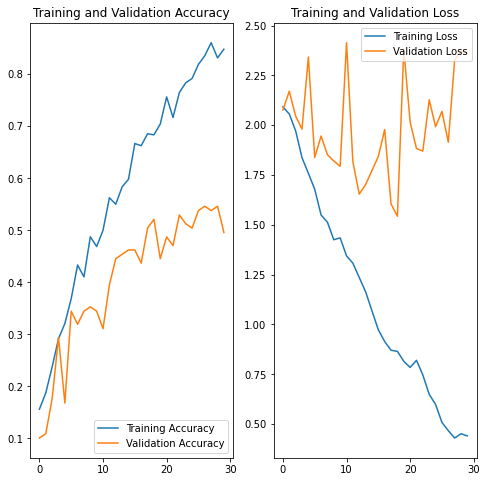

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
scores = model.evaluate(val_ds)

1/1 [==============================] - 1s 1s/step - loss: 2.3613 - accuracy: 0.4958


In [16]:
img_path = test_dir +'/'+ os.listdir(test_dir)[2]

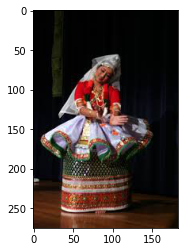

In [17]:
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [18]:
import numpy as np
from keras.preprocessing import image

img = image.load_img(img_path, target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

pred = model.predict(img)

In [19]:
CLASS_NAMES[(np.argmax(pred[0]))]

'manipuri'

In [20]:
model.save('dance.h5')